In [1]:
import os,glob
import nibabel as nib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img

print(tf.__version__)


2.6.2


In [2]:
# tf.debugging.set_log_device_placement(True)


In [3]:
tf.test.is_built_with_cuda()

True

In [4]:
# Set seed value
seed_value = 1
os.environ['PYTHONHASHSEED'] = str(seed_value)
# set python built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# set numpy pseudo-random generator at a fixed value
np.random.seed(seed_value)
# from comet_ml import Experiment
# Set tensorflow pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)
# Configure a new global tensorflow session
from tensorflow.python.keras import backend as K 
session_conf = tf.compat.v1.ConfigProto()
session_conf.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

session = tf.compat.v1.InteractiveSession(config=session_conf)
session

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) 
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Num GPUs Available:  1


In [6]:
K.set_floatx('float16')
K.floatx()

'float16'

In [7]:
#Defining Paths to Dataset
dataInputPath = '/media/anastasis/My Harddisk2/ThesisImages/OAI_2/slices_2/'
imageInputPath = os.path.join(dataInputPath, 'img_train')
maskInputPath = os.path.join(dataInputPath, 'mask_train')

input_img_paths = sorted([
    os.path.join(imageInputPath, fname) for fname in os.listdir(imageInputPath) 
    if fname.endswith('.png') and not fname.startswith('.') 
])

input_mask_paths = sorted([
    os.path.join(maskInputPath, fname) for fname in os.listdir(maskInputPath) 
    if fname.endswith('.png') and not fname.startswith('.') 
])
# print('Number of samples: ',  len(input_img_paths))
# for img_path, mask_path in zip(input_img_paths[:5],input_mask_paths[:5]):
#     print(img_path,'\n',mask_path)

In [8]:
file_IDs = os.listdir(imageInputPath)
label_IDs = os.listdir(maskInputPath)

In [9]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(file_IDs, label_IDs, test_size=0.2, random_state=seed_value)
X_train, X_val, y_train, y_val = train_test_split(file_IDs, label_IDs, test_size=0.2, random_state=seed_value) 

training_data = {'train': X_train, 'validation': X_val}


In [10]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

class MRIData(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=8, dim=(384,384), n_channels=1,
                 n_classes=5, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.ones((self.batch_size, *self.dim, self.n_channels))
        y = np.ones((self.batch_size, *self.dim, self.n_channels))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            ImagePath = os.path.join(imageInputPath,ID)
            X_temp = cv2.imread(ImagePath, 0)
            X_temp = np.array(X_temp)
            X_temp = np.expand_dims(X_temp, axis=2)
            X[i,:,:] = X_temp

             # Store class
            MaskPath = os.path.join(maskInputPath,ID)
            y_temp = cv2.imread(MaskPath, 0)
            y_temp = np.array(y_temp)
            y_temp = np.expand_dims(y_temp, axis=2)
            n,h,w = y_temp.shape
            y_temp = y_temp.reshape(-1,)
            y_temp = labelencoder.fit_transform(y_temp)
            y_temp = y_temp.reshape(n,h,w)
            y[i,:,:] = y_temp

        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes).astype('float16')

In [11]:
#Parameters
params = {'dim':(384,384),
          'batch_size':8,
          'n_classes':5,
          'n_channels':1,
          'shuffle':True}

partition = training_data
training_gen = MRIData(partition['train'],**params)
print('training_gen created',training_gen[0][1].shape,training_gen[0][1].dtype)
# batch1 = training_gen.__getitem__(10000)
validation_gen = MRIData(partition['validation'],**params)
print('validation_gen created',validation_gen[0][1].shape,validation_gen[0][1].dtype)


training_gen created (8, 384, 384, 5) float16
validation_gen created (8, 384, 384, 5) float16


In [12]:
# Defining the DICE COEFFICIENT
def dice_coe(output, target, loss_type='jaccard',axis=(1,2,3),smooth=1e-5):
    inse = tf.reduce_sum(output*target, axis=axis)
    if loss_type == 'jaccard':
        l = tf.reduce_sum(output*output,axis=axis)
        r = tf.reduce_sum(target*target,axis=axis)
    elif loss_type == 'sorensen':
        l = tf.reduce_sum(output,axis=axis)
        r = tf.reduce_sum(target,axis=axis)
    else:
        raise Exception('Unknown loss_type')
    
    dice = (2.*inse+smooth)/(l+r+smooth)

    dice = tf.reduce_mean(dice,name='dice_coe')
    return dice

In [13]:
# Defining the U-NET model

from tensorflow.keras.layers import (BatchNormalization, Conv2D, Conv2DTranspose,Dropout, Input, Lambda, MaxPool2D, UpSampling2D,concatenate)
from tensorflow.keras.models import Model

def multi_unet_model(n_classes = 5, IMG_HEIGHT = 384, IMG_WIDTH = 384, IMG_CHANNELS = 1):
    inputs = Input((IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS))
    
    #Downstream
    c1 = Conv2D(16,(3,3), activation='relu',kernel_initializer='he_normal',padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16,(3,3), activation='relu',kernel_initializer='he_normal',padding='same')(c1)
    p1 = MaxPool2D((2,2))(c1)

    c2 = Conv2D(32,(3,3), activation='relu',kernel_initializer='he_normal',padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32,(3,3), activation='relu',kernel_initializer='he_normal',padding='same')(c2)
    p2 = MaxPool2D((2,2))(c2)

    c3 = Conv2D(64,(3,3), activation='relu',kernel_initializer='he_normal',padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64,(3,3), activation='relu',kernel_initializer='he_normal',padding='same')(c3)
    p3 = MaxPool2D((2,2))(c3)

    c4 = Conv2D(128,(3,3), activation='relu',kernel_initializer='he_normal',padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128,(3,3), activation='relu',kernel_initializer='he_normal',padding='same')(c4)
    p4 = MaxPool2D((2,2))(c4)

    c5 = Conv2D(256,(3,3), activation='relu',kernel_initializer='he_normal',padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256,(3,3), activation='relu',kernel_initializer='he_normal',padding='same')(c5)

    #UpStream
    u6 = Conv2DTranspose(128,(2,2), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6,c4])
    c6 = Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)

    u7 = Conv2DTranspose(64,(2,2), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7,c3])
    c7 = Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)

    u8 = Conv2DTranspose(32,(2,2), strides=(2,2), padding='same')(c7)
    u8 = concatenate([u8,c2])
    c8 = Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)

    u9 = Conv2DTranspose(32,(2,2), strides=(2,2), padding='same')(c8)
    u9 = concatenate([u9,c1])
    c9 = Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)


    outputs = Conv2D(n_classes, (1,1), activation='softmax')(c9)

    model = Model(inputs=[inputs],outputs=[outputs])

    return model


In [15]:
def get_model_memory_usage(batch_size, model):
    import numpy as np
    try:
        from keras import backend as K
    except:
        from tensorflow.keras import backend as K

    shapes_mem_count = 0
    internal_model_mem_count = 0
    for l in model.layers:
        layer_type = l.__class__.__name__
        if layer_type == 'Model':
            internal_model_mem_count += get_model_memory_usage(batch_size, l)
        single_layer_mem = 1
        out_shape = l.output_shape
        if type(out_shape) is list:
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(p) for p in model.non_trainable_weights])

    number_size = 4.0
    if K.floatx() == 'float16':
        number_size = 2.0
    if K.floatx() == 'float64':
        number_size = 8.0

    total_memory = number_size * (batch_size * shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3) + internal_model_mem_count
    return gbytes

In [16]:
get_model_memory_usage(batch_size=8,model=multi_unet_model())

1.618

In [14]:
dice_coefficient = dice_coe
model = multi_unet_model()
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=[dice_coefficient,'accuracy'])


In [17]:
batch_size_unet = 8
epochs_unet = 5

history = model.fit(training_gen,
                    verbose = 1,
                    epochs = epochs_unet,
                    validation_data = validation_gen)

Epoch 1/5
6496/6496 [==============================] - 5180s 796ms/step - loss: 0.0775 - dice_coe: 0.9826 - accuracy: 0.9789 - val_loss: 0.0211 - val_dice_coe: 0.9942 - val_accuracy: 0.9921
Epoch 2/5
6496/6496 [==============================] - 4700s 723ms/step - loss: 0.0218 - dice_coe: 0.9940 - accuracy: 0.9919 - val_loss: 0.0189 - val_dice_coe: 0.9947 - val_accuracy: 0.9928
Epoch 3/5
6496/6496 [==============================] - 4701s 724ms/step - loss: 0.0194 - dice_coe: 0.9946 - accuracy: 0.9926 - val_loss: 0.0171 - val_dice_coe: 0.9951 - val_accuracy: 0.9934
Epoch 4/5
6496/6496 [==============================] - 4552s 701ms/step - loss: 0.0186 - dice_coe: 0.9948 - accuracy: 0.9929 - val_loss: 0.0216 - val_dice_coe: 0.9942 - val_accuracy: 0.9922
Epoch 5/5
6496/6496 [==============================] - 4504s 693ms/step - loss: 0.0182 - dice_coe: 0.9949 - accuracy: 0.9930 - val_loss: 0.0166 - val_dice_coe: 0.9953 - val_accuracy: 0.9935


In [20]:
model.save('/home/anastasis/EMC_Thesis/U_NET/saved_models/B8E5/UNetX2'+'_B'+str(batch_size_unet)+'_E'+str(epochs_unet))
np.save('/home/anastasis/EMC_Thesis/U_NET/saved_models/B8E5/UNetX2_history'+'_B'+str(batch_size_unet)+'_E'+str(epochs_unet)+'.npy', history.history)
print('Model and model history saved')

INFO:tensorflow:Assets written to: /home/anastasis/EMC_Thesis/U_NET/saved_models/B8E5/UNetX2_B8_E5/assets
Model and model history saved


In [21]:
# Plot the training and the validation loss at each epoch
train_loss = history.history['loss']
np.savetxt("/home/anastasis/EMC_Thesis/U_NET/saved_models/B8E5/UNetX2_train_loss"+'_B'+str(batch_size_unet)+'_E'+str(epochs_unet)+".csv", train_loss, delimiter=",")
val_loss = history.history['val_loss']
np.savetxt("/home/anastasis/EMC_Thesis/U_NET/saved_models/B8E5/UNetX2_val_loss"+'_B'+str(batch_size_unet)+'_E'+str(epochs_unet)+".csv", val_loss, delimiter=",")
epochs = range(1, (len(train_loss)+1))
fig = plt.figure()
plt.plot(epochs, train_loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/home/anastasis/EMC_Thesis/U_NET/saved_models/B8E5/UNetX2_TraiValLoss'+'_B'+str(batch_size_unet)+'_E'+str(epochs_unet)+'.png',bbox_inches='tight',dpi=100,facecolor='white')
plt.close(fig)

print('training and validation loss saved')


training and validation loss saved


training and validation dice saved


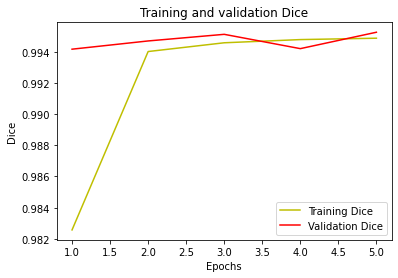

In [22]:
#plot the training and validation dice at each epoch
train_dice = history.history['dice_coe']
np.savetxt("/home/anastasis/EMC_Thesis/U_NET/saved_models/B8E5/UNetX2_train_dice"+'_B'+str(batch_size_unet)+'_E'+str(epochs_unet)+".csv", train_dice, delimiter=",")
val_dice = history.history['val_dice_coe']
np.savetxt("/home/anastasis/EMC_Thesis/U_NET/saved_models/B8E5/UNetX2_val_dice"+'_B'+str(batch_size_unet)+'_E'+str(epochs_unet)+".csv", val_dice, delimiter=",")
epochs = range(1, len(train_dice) + 1)
fig = plt.figure()
plt.plot(epochs, train_dice, 'y', label='Training Dice')
plt.plot(epochs, val_dice, 'r', label='Validation Dice')
plt.title('Training and validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.savefig('/home/anastasis/EMC_Thesis/U_NET/saved_models/B8E5/UNetX2_TrainValDice'+'_B'+str(batch_size_unet)+'_E'+str(epochs_unet)+'.png',bbox_inches='tight',dpi=100,facecolor='white')
# plt.close(fig)

print('training and validation dice saved')
